# <u>Projet Traitement d'Images - MU4RBI07</u>

Binôme : 
- Julie BERNIER 28627942  
- Laurent LIN 3808422

### <u>SUJET</u> : Image Colorization Using Similar Images
Raj Kumar Gupta, Alex Yong-Sang Chia, Deepu Rajan, Ee Sin Ng, and Huang Zhiyong  
Dans : <i>Proc. 20th ACM International Conference on Multimedia</i>, Nara, Japan, pp. 369-378,
2012.

### Installation des bibliotèques 

In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [5]:
from skimage import io, exposure, color, filters, util
import matplotlib.pyplot as plt 
import math
import cv2 
import numpy as np
from skimage.io import imread,imshow
import pims
from skimage import segmentation, feature
from skimage import measure
from skimage.measure import label, regionprops
import matplotlib.image as mpimg
from skimage.draw import ellipse
from scipy import ndimage
from skimage.color import rgb2gray
from skimage.filters import gabor_kernel
from skimage.segmentation import slic 
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from scipy.signal import convolve2d
from PIL import Image

## <u> Importation des images

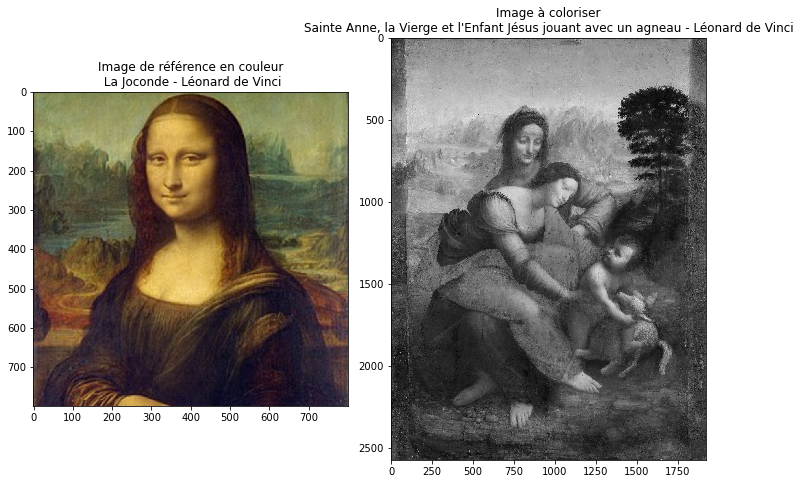

In [6]:
# Lecture des images
image = cv2.imread('Mona_Lisa.jpg')[...,::-1]
image_gray = cv2.imread("vierge.jpg", cv2.IMREAD_GRAYSCALE)
# Affichage
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)
imshow(image)
plt.title('Image de référence en couleur\n La Joconde - Léonard de Vinci')
fig.add_subplot(1, 2, 2)
imshow(image_gray)
plt.title("Image à coloriser\nSainte Anne, la Vierge et l'Enfant Jésus jouant avec un agneau - Léonard de Vinci")
plt.show()

In [7]:
# Dimensions des images
print("Dimension Joconde : ", image.shape)
print("Dimension Vierge : ", image_gray.shape)

Dimension Joconde :  (800, 800, 3)
Dimension Vierge :  (2574, 1920)


## <u> Extraction des superpixels </u>
Afin d'accélérer le processus de colorisation, on extrait des images des superpixels. Pour cela, on utilise SLIC (Simple Linear Iterative Clustering) qui divisent l'image en superpixels. Ces derniers forment un groupe de pixels qui présentent des caractéristiques communes (couleurs, textures, ...).

In [8]:
# Segmentation
segments = slic(image, n_segments=100, compactness=10 ) 
print(f'Nombre de superpixels pour La Joconde: {len(np.unique(segments))}')
segments_gray = slic(image_gray, n_segments=100, compactness=0.1 ) 
print(f'Nombre de superpixels pour La Vierge: {len(np.unique(segments_gray))}')

Nombre de superpixels pour La Joconde: 88
Nombre de superpixels pour La Vierge: 81


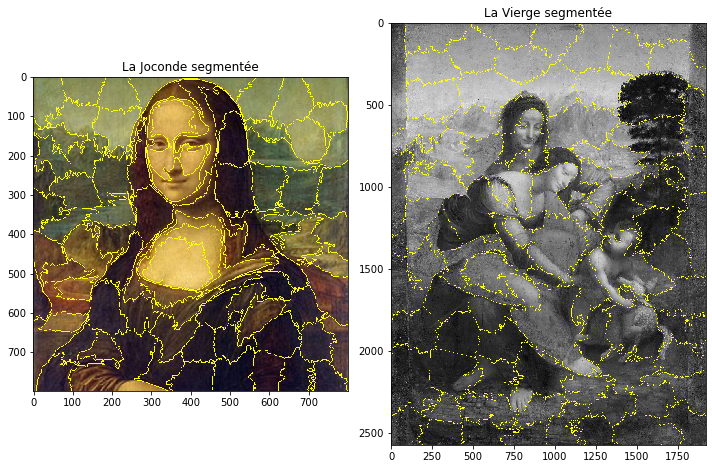

In [9]:
# Affichage
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)
image_superpixels1 = mark_boundaries(image, segments)
imshow(image_superpixels1)
plt.title('La Joconde segmentée')
fig.add_subplot(1, 2, 2)
image_superpixels2 = mark_boundaries(image_gray, segments_gray)
imshow(image_superpixels2)
plt.title("La Vierge segmentée")
plt.show()

## <u>Extraction des caractéristiques</u>
Afin d'obtenir un vecteur à 172 dimensions (2 + 2 + 40 + 128) dépendant de l'intensité, de l'écart-type, des caractéristiques de Gabor et des descripteurs SURF, on extrait ces caractéristiques des images.

### Intensity features
Vecteur à deux dimensions : l'intensité moyenne des pixels du superpixel et l'intensité moyenne des pixels avoisinant le superpixel.

In [10]:
# Intensité moyenne
# Calcul de l'intensité moyenne des pixels des superpixels
image2 = cv2.imread("Mona_Lisa.jpg", cv2.IMREAD_GRAYSCALE)
num_segments = np.max(segments) 
int_features = np.zeros((num_segments, 1))
for i in range(num_segments):
    indices = np.where(segments == i)
    num_pixels = len(indices[0])
    if num_pixels > 0:
        int_features[i, 0] = np.mean(image2[indices])

In [11]:
# Calcul de l'intensité moyenne des pixels avoisinant les superpixels
num_segments = np.max(segments)  #Pour avoir le tableau de l'entrée d'après il faut faire un +1 à cette ligne et l'enlever sinon pb de shape
avg_intensities = np.zeros(num_segments,)

for i in range(num_segments):
    if i != num_segments:
        mask = np.zeros(image.shape[:2], dtype=bool)
        mask[segments == i] = True
        neighbors = np.unique(segments[np.where(cv2.dilate(mask.astype(np.uint8), np.ones((3, 3)), iterations=1) != 0)])
        neighbors = np.delete(neighbors, np.where(neighbors == i))
        avg_intensities[i] = np.mean([np.mean(image2[segments == n]) for n in neighbors])
        avg_intensities[i] = np.nan_to_num(avg_intensities[i], nan=0.0)

C:\Users\laure\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\laure\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [12]:
# Affichage
features = np.column_stack((int_features, avg_intensities.reshape(-1,1)))
print(features)

[[  0.           0.        ]
 [138.01959864 129.64485155]
 [136.02970297 140.34034   ]
 [142.67777479 142.90551959]
 [135.75176909 128.93464032]
 [128.04791074  88.73035583]
 [136.95064882 102.43541985]
 [145.32294997 139.7285153 ]
 [137.84509395 140.82894558]
 [ 74.10690975  93.87453773]
 [ 71.45109954  89.80616069]
 [ 25.39135194  84.75192708]
 [129.90797091 130.32569617]
 [140.32364657 117.76244469]
 [174.89786783 148.78718939]
 [149.68584284 141.79325567]
 [159.51695973 139.58439682]
 [ 22.49141332  54.57537875]
 [127.47804391 117.03239759]
 [ 95.78083054  91.98650482]
 [112.58120511 113.58056258]
 [ 41.80848861  60.42388406]
 [156.52693484 127.18034466]
 [117.63405605 133.64534104]
 [ 87.81441827  83.90744698]
 [ 60.15247982  72.2383884 ]
 [ 88.16458685  97.69285627]
 [167.66640787 144.13300001]
 [ 70.66236311  59.08404691]
 [166.23873072 128.7505661 ]
 [ 53.78965952  57.74753293]
 [ 73.01349528  82.20575758]
 [127.59316129 121.87422376]
 [ 27.25268865  46.72014327]
 [ 83.59845682

### Standard deviation features
Similaire à l'intensité : vecteur à deux dimensions.

In [80]:
taille = 5
image = image2

# Calcul de l'écart-type pour chaque pixel dans une fenêtre de 5x5
std = cv2.blur(image ** 2, (taille, taille)) - cv2.blur(image, (taille, taille)) ** 2
std[std < 0] = 0
std = np.sqrt(std)

# Calcul de l'écart-type pour chaque superpixel
std_feature = np.zeros((np.max(segments)+1, 2))
for i in range(np.max(segments)+1):
    mask = (segments == i)
    neighbors = np.unique(segments[np.where(cv2.dilate(mask.astype(np.uint8), np.ones((3, 3)), iterations=1) != 0)])
    std_feature[i, 0] = np.mean(std[mask])
    std_feature[i, 1] = np.mean(std[neighbors])
    if std_feature is not float:
        std_feature[i,1] = np.nan_to_num(std_feature[i, 1], nan=0.0)
        std_feature[i,0] = np.nan_to_num(std_feature[i, 0], nan=0.0)


In [81]:
# Affichage
print(std_feature)

[[ 0.          0.        ]
 [ 7.71484375  4.40625   ]
 [ 6.49609375  3.81445312]
 [ 8.875       4.19140625]
 [ 6.8359375   4.265625  ]
 [ 4.5546875   4.04296875]
 [ 7.16796875  4.64453125]
 [ 9.578125    4.94140625]
 [ 8.2421875   4.92578125]
 [10.9375      5.82421875]
 [10.8203125   5.38671875]
 [10.8046875   5.10546875]
 [ 9.203125    5.90234375]
 [10.203125    4.91015625]
 [10.8203125   5.7109375 ]
 [10.4921875   5.20703125]
 [10.7890625   4.44140625]
 [10.8359375   6.62109375]
 [ 6.66015625  6.3125    ]
 [10.1953125   6.01953125]
 [ 9.5703125   5.484375  ]
 [10.890625    7.05078125]
 [10.734375    5.5703125 ]
 [ 8.421875    5.171875  ]
 [10.8671875   6.73828125]
 [11.09375     7.49609375]
 [10.8203125   6.63671875]
 [10.8828125   6.27734375]
 [10.9609375   7.61328125]
 [10.796875    6.8671875 ]
 [10.8359375   7.5546875 ]
 [10.828125    6.95703125]
 [ 8.8515625   6.03515625]
 [10.75        7.57421875]
 [10.890625    8.15625   ]
 [10.8828125   7.421875  ]
 [10.796875    7.8046875 ]
 

### Gabor features
Application des filtres Gabor à l'image avec 8 orientations variant par incréments de $\pi/8$ de $0$ à $7\pi/8$, et avec 5 échelles exponentielles exp($i$x$\pi$), $i = 0, 1, 2, 3, 4$ pour calculer une caractéritique à 40 dimensions à chaque pixel.  
La caractéristique de Gabor pour le superpixel est alors calculée comme la moyenne des valeurs de Gabor des pixels composants le superpixel.

In [15]:
image = image2
# Création d'une banque de filtres Gabor
orientations = np.arange(0, 7.1*np.pi/8, np.pi/8)
scales = [1, np.exp(1j*np.pi), np.exp(2j*np.pi), np.exp(3j*np.pi), np.exp(4j*np.pi)]
kernels = []
for scale in scales:
    for theta in orientations:
        kernel = np.real(gabor_kernel(1, theta=theta, sigma_x=scale, sigma_y=scale))
        kernels.append(kernel)

# Applications des filtres à l'image
gabor_features = np.zeros((image.shape[0], image.shape[1], 40))
for i in range(40):
    gabor_features[:,:,i] = convolve2d(image, kernels[i], mode='same')

# Extraction des superpixels
num_segments = np.max(segments) + 1
superpixels = np.zeros((num_segments, 40))
for i in range(num_segments):
    mask = segments == i
    superpixels[i,:] = np.mean(gabor_features[mask,:], axis=0)
    if superpixels[i,:] is not float:
        superpixels[i,:] = np.nan_to_num(superpixels[i,:], nan=0.0)
        superpixels[i,:] = np.nan_to_num(superpixels[i,:], nan=0.0)
        
# Concaténer les caractéristiques de Gabor
gabor_features = superpixels

C:\Users\laure\anaconda3\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [16]:
# Affichage (pour la Joconde)
print(gabor_features)
print(gabor_features.shape)

[[  0.           0.           0.         ...   0.           0.
    0.        ]
 [137.05484542   7.06201662   4.73024134 ...   7.12228805   4.73145781
    7.0614348 ]
 [135.17165252   7.15979509   4.65454065 ...   6.7917054    4.65457088
    7.15977584]
 ...
 [ 41.91254369   2.18448186   1.42537095 ...   2.09153936   1.4301778
    2.18215922]
 [ 23.430534     1.23162959   0.80384388 ...   1.17736485   0.80534466
    1.23087925]
 [ 38.59485451   2.05796942   1.33487192 ...   1.94139497   1.33569892
    2.05764001]]
(89, 40)


### SIFT features
Comme la fonction SURF (utilisée dans l'article) est protégée par un brevet et ne peut être utilisée gratuitement dans la bibliotèque OpenCV, nous utilisons alors un alternatif afin de pouvoir obtenir un descripteur pour chaque pixel : SIFT, qui permet également d'obtenir un descripteur à 128 dimensions.

In [17]:
# Pour l'image de référence

# Charger l'image en niveaux de gris
img_1 = cv2.imread("Mona_Lisa.jpg")
gray_1 = cv2.cvtColor(img_1,cv2.COLOR_BGR2GRAY)

# Créer un extracteur de descripteurs SIFT
sift = cv2.SIFT_create()

# Détecter et calculer les descripteurs pour chaque pixel
kp_1 = [cv2.KeyPoint(x, y, 1) for y in range(img_1.shape[0]) for x in range(img_1.shape[1])]
kp_1, des_1 = sift.compute(img_1, kp_1)
des_1 = np.reshape(des_1, img_1.shape[0]*img_1.shape[1]*128)
des_1 = np.reshape(des_1, (img_1.shape[0],img_1.shape[1],128))

# Afficher la taille des descripteurs
print("Taille des descripteurs : ", des_1.shape)

Taille des descripteurs :  (800, 800, 128)


In [18]:
# Pour l'image cible

# Charger l'image en niveaux de gris
img_2 = cv2.imread("vierge.jpg")
gray_2 = cv2.cvtColor(img_2,cv2.COLOR_BGR2GRAY)

# Créer un extracteur de descripteurs SIFT
sift = cv2.SIFT_create()

# Détecter et calculer les descripteurs pour chaque pixel
kp_2 = [cv2.KeyPoint(x, y, 1) for y in range(img_2.shape[0]) for x in range(img_2.shape[1])]
kp_2, des_2 = sift.compute(img_2, kp_2)
des_2 = np.reshape(des_2, img_2.shape[0]*img_2.shape[1]*128)
des_2 = np.reshape(des_2, (img_2.shape[0],img_2.shape[1],128))

# Afficher la taille des descripteurs
print("Taille des descripteurs : ", des_2.shape)

Taille des descripteurs :  (2574, 1920, 128)


In [19]:
# Calcul de la moyenne des descripteurs pour chaque superpixel de référence
descriptors_per_segment_1 = np.zeros((np.max(segments)+1, 128))
segment_sizes_1 = np.zeros(np.max(segments)+1)
for i in range(img_1.shape[0]):
    for j in range(img_1.shape[1]):
        segment_id = segments[i, j]
        descriptors_per_segment_1[segment_id] += des_2[i, j]
        segment_sizes_1[segment_id] += 1

for i in range(np.max(segments)):
    if segment_sizes_1[i] != 0:
        descriptors_per_segment_1[i] /= segment_sizes_1[i]

# Affichage des descripteurs moyens par superpixels de référence
print(descriptors_per_segment_1.shape) # il faut enlever la première valeur (nulle)
print(descriptors_per_segment_1)

(89, 128)
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.34591010e+01 1.88865157e+01 1.49577514e+01 ... 1.65107382e+01
  2.23483159e+01 2.84532332e+01]
 [1.82958111e+01 1.58525514e+01 1.86775324e+01 ... 1.72208682e+01
  2.63849200e+01 2.51712110e+01]
 ...
 [2.14217511e+01 2.29299878e+01 1.86709884e+01 ... 1.26432276e+01
  1.16706833e+01 1.57040879e+01]
 [1.48534567e+01 1.60489412e+01 1.90981630e+01 ... 2.23284252e+01
  2.66293647e+01 1.56262796e+01]
 [1.71593000e+05 1.07274000e+05 6.86370000e+04 ... 6.28460000e+04
  9.74330000e+04 1.64142000e+05]]


In [20]:
# Calcul de la moyenne des descripteurs pour chaque superpixel cible
descriptors_per_segment_2 = np.zeros((np.max(segments_gray)+1, 128))
segment_sizes_2 = np.zeros(np.max(segments_gray)+1)
for i in range(img_2.shape[0]):
    for j in range(img_2.shape[1]):
        segment_id = segments_gray[i, j]
        descriptors_per_segment_2[segment_id] += des_2[i, j]
        segment_sizes_2[segment_id] += 1

for i in range(np.max(segments_gray)):
    if segment_sizes_2[i] != 0:
        descriptors_per_segment_2[i] /= segment_sizes_2[i]

# Affichage des descripteurs moyens par superpixels cibles
print(descriptors_per_segment_2.shape) # il faut enlever la première valeur
print(descriptors_per_segment_2)

(82, 128)
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.90294303e+01 1.81650648e+01 1.26423458e+01 ... 1.31805588e+01
  1.79404269e+01 2.95504922e+01]
 [1.91680268e+01 1.44620650e+01 1.51868583e+01 ... 2.00074940e+01
  2.67194756e+01 2.61702382e+01]
 ...
 [1.56872122e+01 1.89248153e+01 2.50434829e+01 ... 1.93837957e+01
  2.26630609e+01 1.91562333e+01]
 [1.54757843e+01 1.87716163e+01 2.80414394e+01 ... 1.59405383e+01
  2.19327326e+01 1.68792683e+01]
 [5.57494000e+05 7.34470000e+05 9.65903000e+05 ... 6.21235000e+05
  7.91216000e+05 6.19237000e+05]]


## <u> Correspondance en cascade pour l'attribution initiale des couleurs </u>
Pour exploiter des caractéristiques extraites aux étapes précédentes, on recherche parmis les superpixels de référence ceux qui on des caractéristiques les plus similaires pour chaque superpixels cible.

### Cascade Gabor 

In [21]:
# Charger l'image de référence
ref_img = io.imread('Mona_Lisa.jpg')
# Convertir en nuances de gris
ref_gray = color.rgb2gray(ref_img)

# Création d'une banque de filtres Gabor
orientations = np.arange(0, 7.1*np.pi/8, np.pi/8)
scales = [1, np.exp(1j*np.pi), np.exp(2j*np.pi), np.exp(3j*np.pi), np.exp(4j*np.pi)]
kernels = []
for scale in scales:
    for theta in orientations:
        kernel = np.real(gabor_kernel(1, theta=theta, sigma_x=scale, sigma_y=scale))
        kernels.append(kernel)

# Convoluer l'image de référence avec les filtres de Gabor
ref_gabor_features = np.zeros((ref_gray.shape[0], ref_gray.shape[1], 40))
for i in range(40):
    ref_gabor_features[:,:,i] = convolve2d(ref_gray, kernels[i], mode='same')

# Appliquer la segmentation SLIC à l'image de référence
ref_segments = slic(ref_img, n_segments=100, compactness=10)
# Extraire les superpixels
ref_num_segments = len(np.unique(segments)) #J'ai changé ici
ref_superpixels = np.zeros((ref_num_segments, 40))
for i in range(ref_num_segments):
    mask = ref_segments == i
    ref_superpixels[i,:] = np.mean(ref_gabor_features[mask,:], axis=0)
    ref_superpixels[i,:] = np.nan_to_num(ref_superpixels[i,:], nan=0.0)

# Charger l'image cible
tgt_img = cv2.imread('vierge.jpg')[...,::-1]
# Convertir en nuances de gris
tgt_gray = color.rgb2gray(tgt_img)

# Convoluer l'image cible avec les filtres de Gabor
tgt_gabor_features = np.zeros((tgt_gray.shape[0], tgt_gray.shape[1], 40))
for i in range(40):
    tgt_gabor_features[:,:,i] = convolve2d(tgt_gray, kernels[i], mode='same')

# Appliquer la segmentation SLIC à l'image cible
tgt_segments = slic(image_gray, n_segments=100, compactness=0.1)
# Extraire les superpixels
tgt_num_segments = np.max(tgt_segments) 
tgt_superpixels = np.zeros((tgt_num_segments, 40))
for i in range(tgt_num_segments):
    mask = tgt_segments == i
    tgt_superpixels[i,:] = np.mean(tgt_gabor_features[mask,:], axis=0)
    tgt_superpixels[i,:] = np.nan_to_num(tgt_superpixels[i,:], nan=0.0)

In [22]:
print(tgt_superpixels)
print(tgt_superpixels.shape)
print(ref_superpixels)
print(ref_superpixels.shape)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.45536147 0.02293169 0.01552209 ... 0.02345871 0.01551711 0.02293411]
 [0.55570766 0.02845396 0.01888822 ... 0.02792057 0.0189019  0.02844722]
 ...
 [0.15962175 0.00795529 0.00530112 ... 0.00788088 0.00529923 0.00795576]
 [0.16033707 0.00808738 0.00536371 ... 0.007939   0.00536647 0.00808603]
 [0.21767048 0.01114733 0.0074032  ... 0.010954   0.00740229 0.01115002]]
(81, 40)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.5484598  0.02826369 0.01892978 ... 0.02850041 0.01893476 0.02826155]
 [0.54068243 0.0286442  0.01862078 ... 0.02716998 0.01862047 0.02864434]
 ...
 [0.08485285 0.00436348 0.00286902 ... 0.0042064  0.00285448 0.00437035]
 [0.0858751  0.00446196 0.00294867 ... 0.00433602 0.00294864 0.00446171]
 [0.15640361 0.00812899 0.00528932 ... 0.00777383 0.00532933 0.00811115]]
(88, 40)


In [28]:
# Définir le nombre de superpixels de référence à utiliser
alpha = 20
iteration = 0
indice = []
# Itérer sur les superpixels cibles et trouver les superpixels de référence
# les plus similaires basés sur les caractéristiques de Gabor
for i in range(tgt_num_segments):
    tgt_superpixel = tgt_superpixels[i,:]
    dists = np.linalg.norm(tgt_superpixel - ref_superpixels, axis=1)
    most_similar_idx = np.argsort(dists)[:alpha]
    indice.append(most_similar_idx)
    iteration += 1
    most_similar_superpixels = ref_superpixels[most_similar_idx,:]


In [24]:
# Affichage des dimensions et de la première liste d'indice correspondant
indice = np.array(indice)
print(indice[0])
print(indice.shape)

[ 0 84 17 74 63 85 86 79 11 33 80 70 59 77 83 37 68 41 52 65]
(81, 20)


In [32]:
min_index_gabor = []
index = 0
distance_gabor = []
for i in range(tgt_num_segments):
    tgt_superpixel = tgt_superpixels[i,:]
    dists = np.linalg.norm(tgt_superpixel - ref_superpixels, axis=1)
    distance_gabor.append(dists)
    for i in range(len(distance_gabor)):
        min_dist = distance_gabor[i][0]
        for j in range(len(distance_gabor[0])):
        # Si la distance actuelle est plus petite que la plus petite distance enregistrée jusqu'à présent
            if distance_gabor[i][j] < min_dist:
                # Mettre à jour la plus petite distance et son indice
                min_dist = distance_gabor[i][j]
                index = j
        min_index_gabor.append(index)
    distance_gabor = []

In [33]:
#Meilleur indice pour la cascade F
print(min_index_gabor)

[0, 45, 13, 3, 7, 49, 57, 16, 16, 15, 14, 14, 14, 55, 55, 37, 55, 10, 69, 3, 16, 19, 14, 69, 16, 6, 22, 25, 51, 34, 23, 22, 2, 65, 81, 66, 54, 73, 64, 77, 81, 61, 23, 20, 81, 24, 39, 28, 48, 75, 62, 1, 61, 46, 28, 40, 38, 76, 40, 37, 21, 73, 40, 76, 73, 62, 60, 50, 51, 10, 25, 34, 31, 67, 30, 81, 82, 42, 78, 78, 71]


### Cascade intensity value

In [34]:
# Charger l'image de référence et extraire les superpixels
reference_image = cv2.imread('Mona_Lisa.jpg')
reference_superpixels = slic(reference_image, n_segments=100, compactness=10)

# Charger l'image cible et extraire les superpixels
target_image = cv2.imread('vierge.jpg')
gray_img = cv2.imread("vierge.jpg", cv2.IMREAD_GRAYSCALE)
target_superpixels = slic(image_gray, n_segments=100, compactness=0.1)


# Valeurs de l'intensité moyenne
# Calcul de l'intensité moyenne de chaque superpixels
num_segments = np.max(target_superpixels) +1
int_features = np.zeros((num_segments, 1))
for i in range(num_segments):
    indices = np.where(target_superpixels == i)
    num_pixels = len(indices[0])
    if num_pixels > 0:
        int_features[i, 0] = np.mean(gray_img[indices])
image = gray_img
# Calcul de l'intensité moyenne des pixels avoisinants chaque superpixels
num_segments = np.max(target_superpixels)    #Pour avoir le tableau de l'entrée d'après il faut faire un +1 à cette ligne et l'enlever sinon pb de shape
avg_intensities2 = np.zeros(num_segments,)

for i in range(num_segments):
    if i != num_segments:
        mask = np.zeros(image.shape[:2], dtype=bool)
        mask[target_superpixels == i] = True
        neighbors = np.unique(target_superpixels[np.where(cv2.dilate(mask.astype(np.uint8), np.ones((3, 3)), iterations=1) != 0)])
        neighbors = np.delete(neighbors, np.where(neighbors == i))
        avg_intensities2[i] = np.mean([np.mean(image[target_superpixels == n]) for n in neighbors])
        avg_intensities2[i] = np.nan_to_num(avg_intensities2[i], nan=0.0)

reference_superpixels = avg_intensities
target_superpixels = avg_intensities2
# Calcul distance Euclidienne entre chaque superpixel cible et chaque superpixel de référence
distances = np.zeros((len(target_superpixels), len(reference_superpixels)))
for i, target_superpixel_intensity in enumerate(target_superpixels):
    for j, reference_superpixel_intensity in enumerate(reference_superpixels):
        distances[i, j] = np.linalg.norm(target_superpixel_intensity - reference_superpixel_intensity)

# trouver les α superpixels de référence les plus similaires pour chaque superpixel cible       
alpha = 5
most_similar_reference_superpixels = []
for i, target_superpixel in enumerate(target_superpixels):
    indices = np.argsort(distances[i])[:alpha]
    similar_superpixels = [reference_superpixels[j] for j in indices]
    most_similar_reference_superpixels.append(similar_superpixels)


In [35]:
reference_superpixels = avg_intensities
target_superpixels = avg_intensities2
distance = []
total = []
index = 0
min_index_superpixel = []
# Calcul distance Euclidienne entre chaque superpixel cible et chaque superpixel de référence
for m in  (avg_intensities2):
    for  n in  (avg_intensities):
        distance.append(np.linalg.norm(m-n))

    min_distance = distance[0]
    for i in range(len(distance)):
        # Si la distance actuelle est plus petite que la plus petite distance enregistrée jusqu'à présent
        if distance[i] < min_distance:
            # Mettre à jour la plus petite distance et son indice
            min_distance = distance[i]
            index = i
    distance = []
    min_index_superpixel.append(index)

In [36]:
#Meilleur indice pour la cascade intensité
print(min_index_superpixel)

[0, 53, 14, 53, 53, 53, 53, 53, 12, 34, 53, 53, 14, 23, 53, 12, 53, 42, 14, 20, 53, 6, 27, 56, 3, 18, 6, 76, 1, 14, 31, 20, 45, 68, 20, 42, 26, 64, 56, 37, 54, 19, 56, 25, 68, 36, 63, 26, 63, 19, 66, 19, 49, 59, 50, 64, 36, 67, 25, 67, 52, 66, 38, 58, 46, 64, 58, 63, 51, 47, 68, 66, 28, 61, 68, 68, 58, 86, 41, 41, 68]


### Cascade Standard Deviation


In [79]:
# Standard Deviation pour l'image target
# Importation de l'image et de la taille de la fenêtre de calcul (5x5)
taille = 5
gray_img = cv2.imread("vierge.jpg", cv2.IMREAD_GRAYSCALE)

image = gray_img
# Calul de l'écart-type pour chaque pixel dans une fenêtre 5x5
target_superpixels = slic(image_gray, n_segments=100, compactness=0.1)

std2 = cv2.blur(image ** 2, (taille, taille)) - cv2.blur(image, (taille, taille)) ** 2
std2[std2 < 0] = 0
std2 = np.sqrt(std2)

# Calcul de l'écart-type pour chaque superpixel
std_feature2 = np.zeros((num_segments+1, 2))
for i in range(num_segments):
    mask2 = (target_superpixels == i)
    neighbors2 = np.unique(target_superpixels[np.where(cv2.dilate(mask2.astype(np.uint8), np.ones((3, 3)), iterations=1) != 0)])
    std_feature2[i, 0] = np.mean(std2[mask2])
    std_feature2[i, 1] = np.mean(std2[neighbors2])
    if std_feature2 is not float:
        std_feature2[i,1] = np.nan_to_num(std_feature2[i, 1], nan=0.0)
        std_feature2[i,0] = np.nan_to_num(std_feature2[i, 0], nan=0.0)

In [83]:
std_feature = std_feature[1:]
print(std_feature.shape)

std_feature2 = std_feature2[1:]
print(std_feature2.shape)

(88, 2)
(81, 2)


In [43]:
std_ref = std_feature
std_targ = std_feature2
distance_std = []
total = []
index = 0
min_index_std = []
# Calcul distance Euclidienne entre chaque superpixel cible et chaque superpixel de référence
for m in  (std_targ):
    for  n in  (std_ref):
        distance_std.append(np.linalg.norm(m-n))
    min_distance = distance_std[0]
    for i in range(len(distance_std)):
        # Si la distance actuelle est plus petite que la plus petite distance enregistrée jusqu'à présent
        if distance_std[i] < min_distance:
            # Mettre à jour la plus petite distance et son indice
            min_distance = distance_std[i]
            index = i
    distance_std = []
    min_index_std.append(index)

In [44]:
#Meilleur indice pour la cascade std_deviation
print(min_index_std)

[40, 40, 40, 40, 32, 40, 40, 32, 40, 36, 36, 36, 36, 36, 40, 38, 39, 37, 44, 37, 43, 37, 43, 47, 44, 47, 50, 53, 48, 52, 46, 54, 56, 60, 68, 69, 68, 72, 60, 86, 83, 72, 85, 71, 83, 83, 83, 83, 82, 83, 54, 73, 83, 83, 83, 83, 83, 83, 83, 83, 83, 85, 83, 83, 83, 83, 83, 83, 71, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 3]


### Cascade SIFT


In [45]:
# Charger l'image de référence et extraire les superpixels
img_1 = cv2.imread('Mona_Lisa.jpg')[...,::-1]
segments_1 = slic(img_1, n_segments=100, compactness=10 )
print(f'Nombre de superpixels pour Mona Lisa: {len(np.unique(segments_1))}')

# Charger l'image cible et extraire les superpixels
img_2 = cv2.imread('vierge.jpg', cv2.IMREAD_GRAYSCALE)
segments_2 = slic(img_2, n_segments=100, compactness=0.1)
print(f'Nombre de superpixels pour La Vierge: {len(np.unique(segments_2))}')

Nombre de superpixels pour Mona Lisa: 88
Nombre de superpixels pour La Vierge: 81


In [46]:
# Créer un extracteur de descripteurs SIFT
sift = cv2.SIFT_create()

# Détecter et calculer les descripteurs pour chaque pixel de l'image de référence
kp_1 = [cv2.KeyPoint(x, y, 1) for y in range(img_1.shape[0]) for x in range(img_1.shape[1])]
kp_1, des_1 = sift.compute(img_1, kp_1)
des_1 = np.reshape(des_1, img_1.shape[0]*img_1.shape[1]*128)
des_1 = np.reshape(des_1, (img_1.shape[0],img_1.shape[1],128))

# Détecter et calculer les descripteurs pour chaque pixel de l'image cible
kp_2 = [cv2.KeyPoint(x, y, 1) for y in range(img_2.shape[0]) for x in range(img_2.shape[1])]
kp_2, des_2 = sift.compute(img_2, kp_2)
des_2 = np.reshape(des_2, img_2.shape[0]*img_2.shape[1]*128)
des_2 = np.reshape(des_2, (img_2.shape[0],img_2.shape[1],128))

In [47]:
# Calcul de la moyenne des descripteurs pour chaque superpixel de référence
descriptors_per_segment_1 = np.zeros((np.max(segments_1)+1, 128))
segment_sizes_1 = np.zeros(np.max(segments_1)+1)
for i in range(img_1.shape[0]):
    for j in range(img_1.shape[1]):
        segment_id = segments_1[i, j]
        descriptors_per_segment_1[segment_id] += des_1[i, j]
        segment_sizes_1[segment_id] += 1

for i in range(np.max(segments_1)):
    if segment_sizes_1[i] != 0:
        descriptors_per_segment_1[i] /= segment_sizes_1[i]
        
descriptors_per_segment_1 = descriptors_per_segment_1[1:]
print(descriptors_per_segment_1)
print(descriptors_per_segment_1.shape)

# Calcul de la moyenne des descripteurs pour chaque superpixel cible
descriptors_per_segment_2 = np.zeros((np.max(segments_2)+1, 128))
segment_sizes_2 = np.zeros(np.max(segments_2)+1)
for i in range(img_2.shape[0]):
    for j in range(img_2.shape[1]):
        segment_id = segments_2[i, j]
        descriptors_per_segment_2[segment_id] += des_2[i, j]
        segment_sizes_2[segment_id] += 1

for i in range(np.max(segments_2)):
    if segment_sizes_2[i] != 0:
        descriptors_per_segment_2[i] /= segment_sizes_2[i]

descriptors_per_segment_2 = descriptors_per_segment_2[1:]
print(descriptors_per_segment_2)
print(descriptors_per_segment_2.shape)

[[2.74122756e+01 1.50059852e+01 1.07805422e+01 ... 1.63222626e+01
  1.90979932e+01 2.61804952e+01]
 [1.79541508e+01 1.07727342e+01 1.12306169e+01 ... 1.88432597e+01
  2.58750952e+01 2.90079208e+01]
 [2.01314163e+01 9.13047568e+00 9.75705456e+00 ... 2.21476754e+01
  2.59931470e+01 2.90060468e+01]
 ...
 [2.37972849e+01 1.16131788e+01 1.17344417e+01 ... 9.03523490e+00
  1.07094265e+01 2.61086028e+01]
 [1.84033095e+01 1.87837610e+01 1.92539616e+01 ... 1.85753751e+01
  1.66233347e+01 1.55809844e+01]
 [1.65798000e+05 1.45792000e+05 9.96970000e+04 ... 7.46070000e+04
  7.11250000e+04 9.10490000e+04]]
(88, 128)
[[2.90294303e+01 1.81650648e+01 1.26423458e+01 ... 1.31805588e+01
  1.79404269e+01 2.95504922e+01]
 [1.91680268e+01 1.44620650e+01 1.51868583e+01 ... 2.00074940e+01
  2.67194756e+01 2.61702382e+01]
 [1.70409922e+01 1.31046796e+01 1.44330703e+01 ... 2.29542466e+01
  2.95071419e+01 2.48397950e+01]
 ...
 [1.56872122e+01 1.89248153e+01 2.50434829e+01 ... 1.93837957e+01
  2.26630609e+01 1.915

In [48]:
# Définir le nombre de superpixels de référence à utiliser
alpha_sift = 20
iteration_sift = 0
indice_sift = []

# Itérer sur les superpixels cibles et trouver les superpixels de référence
# les plus similaires basés sur les caractéristiques de Gabor
for i in range(np.max(segments_2)):
    descri = descriptors_per_segment_2[i,:]
    dists = np.linalg.norm(descri - descriptors_per_segment_1, axis=1)
    most_similar_idx = np.argsort(dists)[:alpha_sift]
    indice_sift.append(most_similar_idx)
#     print(most_similar_idx)
#     print('')
    iteration_sift += 1
    most_similar_superpixels = descriptors_per_segment_1[most_similar_idx,:]
#     Dessiner les superpixels de référence les plus similaires sur l'image cible
#     for j in range(alpha):
#         ref_superpixel_idx = most_similar_idx[j]
#         mask = ref_segments == ref_superpixel_idx
#         x,y = np.nonzero(mask)
#         tgt_img[x,y] = ref_img[x,y]

In [49]:
indice_sift = np.array(indice_sift)
print(indice_sift)
print(indice_sift.shape)

[[ 0 37 66 ...  6 26  1]
 [56  1 52 ... 13 36  3]
 [56  2  1 ... 36  7  0]
 ...
 [35 33 34 ... 73 27 59]
 [84 34 65 ... 18 61 13]
 [87 42 80 ... 18 53 81]]
(81, 20)


In [50]:
#indice du minimum SIFT
min_index_sift = []
for i in range (len(indice_sift)) :
    min_index_sift.append(indice_sift[i][0])

In [51]:
#Meilleur indice pour la cascade SIFT
print(min_index_sift)

[0, 56, 56, 56, 6, 6, 52, 52, 86, 52, 6, 52, 52, 52, 33, 52, 21, 71, 49, 81, 33, 21, 35, 21, 86, 80, 23, 33, 33, 81, 35, 32, 33, 86, 30, 30, 66, 81, 36, 86, 83, 21, 21, 36, 33, 21, 83, 35, 52, 86, 59, 21, 21, 33, 21, 86, 86, 61, 86, 86, 86, 59, 86, 35, 35, 52, 80, 35, 80, 34, 80, 80, 80, 33, 80, 86, 35, 34, 35, 84, 87]


### Cascade F utilisant les filtres Gabor, Intensity, Std Deviation et SIFT


In [55]:
w1 = 0.2 #Gabor
w2 = 0.5 #SIFT
w3 = 0.2 #Intensity
w4 = 0.1 #Standard Deviation

In [84]:
# Définir le nombre de superpixels de référence à utiliser
alpha = 20
iteration = 0
dist_gabor = 0
dist_intense = 0
dist_std = 0
slic_target = slic(image_gray, n_segments=100, compactness=0.1)
F = np.zeros(len(np.unique(slic_target)))
intensity_2 = avg_intensities2
intensity_1 = avg_intensities
standard_2 = std_feature2
standard_1 = std_feature
gabor_2 = tgt_superpixels
gabor_1 = ref_superpixels
sift_2 = descriptors_per_segment_2
sift_1 = descriptors_per_segment_1
ind_F = []
index = 0


In [86]:
# Itérer sur les superpixels cibles et trouver les superpixels de référence
# les plus similaires basés sur les caractéristiques de Gabor
for k in range (len(np.unique(slic_target))): #Bizarrement t'as des methodes ou y'a + ou - 80 superpixels 
        for j in (indice[k]):
            dist_gabor = np.linalg.norm(gabor_2[k] - gabor_1[j])
            dist_sift = np.linalg.norm(sift_2[k] - sift_1[j])
            dist_std = np.linalg.norm(standard_2[k] - standard_1[j])
            dist_intense = (intensity_2[k]- intensity_1[j])
            F[k] = abs(w1 * dist_gabor + w2 * dist_sift + w3 * dist_intense + w4 * dist_std)
            min_F = F[0]
            if F[k] < min_F:
            # Mettre à jour la plus petite distance et son indice
                F[k] = min_F
                index = j
        ind_F.append(index)
            

In [87]:
print(ind_F) 

[0, 1, 5, 27, 14, 2, 3, 32, 32, 32, 5, 32, 32, 32, 32, 86, 32, 34, 71, 23, 32, 36, 12, 30, 32, 45, 57, 31, 40, 54, 13, 32, 20, 33, 36, 25, 57, 38, 32, 21, 40, 71, 13, 26, 60, 64, 57, 40, 30, 26, 59, 16, 34, 31, 40, 10, 21, 40, 66, 86, 30, 35, 76, 38, 38, 59, 42, 31, 42, 34, 31, 61, 42, 81, 52, 82, 68, 66, 38, 38, 38, 38, 1, 5, 27, 14, 2, 3, 32, 32, 32, 5, 32, 32, 32, 32, 86, 32, 34, 71, 23, 32, 36, 12, 30, 32, 45, 57, 31, 40, 54, 13, 32, 20, 33, 36, 25, 57, 38, 32, 21, 40, 71, 13, 26, 60, 64, 57, 40, 30, 26, 59, 16, 34, 31, 40, 10, 21, 40, 66, 86, 30, 35, 76, 38, 38, 59, 42, 31, 42, 34, 31, 61, 42, 81, 52, 82, 68, 66, 38, 38, 38]


## <u>Cielab color space transfert</u>

In [89]:
import cv2
from skimage.segmentation import slic
import numpy as np

# Chargement des images
img_ref = cv2.imread('Mona_Lisa.jpg')
img_gray = cv2.imread('vierge.jpg', 0)

# Segmenter l'image de référence en superpixels
segments = segments

# Extraire les valeurs a et b de chaque pixel de l'image de référence en CIELab
img_ref_lab = cv2.cvtColor(img_ref, cv2.COLOR_BGR2LAB)
L , a, b = cv2.split(img_ref_lab) #Luminosity, a channel, b channel

In [90]:
props = regionprops(segments)
tab_a = []
tab_b = []
a_mean = []
b_mean = []
#La j'ai les valeurs moyennes a et b de chaque superpixel de référence
for i in range(len(props)):
    indices = props[i].coords
    x, y = indices[:,0], indices[:,1]
    for k in range(len(x)):
        tab_a.append(a[x[k],y[k]])
        tab_b.append(b[x[k],y[k]])
    a_mean.append(int(np.mean(tab_a)))
    b_mean.append(int(np.mean(tab_b)))
    tab_a = []
    tab_b = []


In [91]:
#Trouver la centroide de chaque superpixel target
props_target = regionprops(segments_gray)
x_mean = 0
y_mean = 0
center_x = []
center_y = []
for i in range(len(props_target)):
    indices = props_target[i].coords
    x, y = indices[:,0], indices[:,1]
    center_x.append(int(np.mean(x)))
    center_y.append(int(np.mean(y)))

In [92]:
# Transposer la meilleur valeur refenrece (a,b) au centre de chaque superpixel target 
# Extraire les valeurs a et b de chaque pixel de l'image target en CIELab
img_targ_lab = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
img_targ_lab = cv2.cvtColor(img_targ_lab, cv2.COLOR_BGR2LAB)
L_t, a_t, b_t = cv2.split(img_targ_lab) #Luminosity, a channel, b channel de l'image target
for i in range (len(np.unique(segments_gray))):
    a_t[[center_x[i]],[center_y[i]]] = a_mean[ind_F[i]]
    b_t[[center_x[i]],[center_y[i]]] = b_mean[ind_F[i]]


### Attribution (a,b) pour les pixels voisins

In [93]:
#Obtention d'un sigma adaptatif
sigma = []
liste_1 = []
liste_2 = []
for i in range (len(props_target)):
    indices = props_target[i].coords
    x, y = indices[:,0], indices[:,1]
    for k in range (len(x)):
        liste_1.append(L_t[x[k],y[k]])
    sigma.append(np.var(liste_1))
    liste_1 = []


In [94]:
# Détermination des valeurs (a,b) pour tous les pixels
w_pq = []
for i in range (len(props_target)):
    indices = props_target[i].coords
    x, y = indices[:,0], indices[:,1]
    for k in range (len(x)):
        w_pq = np.exp((-(L_t[center_x[i],center_y[i]]-L_t[x[k],y[k]])**2)/(2*sigma[i]**2))
        a_t[x[k],y[k]] = a_mean[ind_F[i]] + w_pq * a_t[x[k],y[k]]
        b_t[x[k],y[k]] = b_mean[ind_F[i]] + w_pq * b_t[x[k],y[k]]


C:\Users\laure\AppData\Local\Temp\ipykernel_14856\3840480997.py:7: RuntimeWarning: overflow encountered in ubyte_scalars
  w_pq = np.exp((-(L_t[center_x[i],center_y[i]]-L_t[x[k],y[k]])**2)/(2*sigma[i]**2))


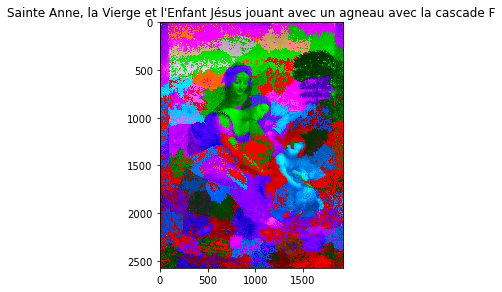

In [95]:
#Affichage de l'image target
color_target = cv2.merge((L_t, a_t, b_t))
color_target = cv2.cvtColor(color_target, cv2.COLOR_LAB2RGB);
imshow(color_target)
plt.title("Sainte Anne, la Vierge et l'Enfant Jésus jouant avec un agneau avec la cascade F")
plt.show()

### Merge  l'intensité



In [96]:
#min_index_superpixel = min_index pour l'intensité
props = regionprops(segments)
tab_a = []
tab_b = []
a_mean = []
b_mean = []
#Ici il y a les valeurs moyennes a et b de chaque superpixel de référence
for i in range(len(props)):
    indices = props[i].coords
    x, y = indices[:,0], indices[:,1]
    for k in range(len(x)):
        tab_a.append(a[x[k],y[k]])
        tab_b.append(b[x[k],y[k]])
    a_mean.append(int(np.mean(tab_a)))
    b_mean.append(int(np.mean(tab_b)))
    tab_a = []
    tab_b = []


In [97]:
#Trouver la centroide de chaque superpixel target
props_target = regionprops(segments_gray)
x_mean = 0
y_mean = 0
center_x = []
center_y = []
for i in range(len(props_target)):
    indices = props_target[i].coords
    x, y = indices[:,0], indices[:,1]
    center_x.append(int(np.mean(x)))
    center_y.append(int(np.mean(y)))

# Transposer la meilleur valeur refenrece (a,b) au centre de chaque superpixel target 
# Extraire les valeurs a et b de chaque pixel de l'image target en CIELab
img_targ_lab = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
img_targ_lab = cv2.cvtColor(img_targ_lab, cv2.COLOR_BGR2LAB)
L_t, a_t, b_t = cv2.split(img_targ_lab) #Luminosity, a channel, b channel
for i in range (len(np.unique(segments_gray))):
    a_t[[center_x[i]],[center_y[i]]] = a_mean[min_index_superpixel[i]]
    b_t[[center_x[i]],[center_y[i]]] = b_mean[min_index_superpixel[i]]


In [98]:
# Détermination des valeurs (a,b) pour tous les pixels
w_pq = []

for i in range (len(props_target)):
    indices = props_target[i].coords
    x, y = indices[:,0], indices[:,1]
    for k in range (len(x)):
        w_pq = np.exp((-(L_t[center_x[i],center_y[i]]-L_t[x[k],y[k]])**2)/(2*sigma[i]**2))
        a_t[x[k],y[k]] = a_mean[min_index_superpixel[i]] + w_pq * a_t[x[k],y[k]]
        b_t[x[k],y[k]] = b_mean[min_index_superpixel[i]] + w_pq * b_t[x[k],y[k]]

C:\Users\laure\AppData\Local\Temp\ipykernel_14856\1498205600.py:8: RuntimeWarning: overflow encountered in ubyte_scalars
  w_pq = np.exp((-(L_t[center_x[i],center_y[i]]-L_t[x[k],y[k]])**2)/(2*sigma[i]**2))


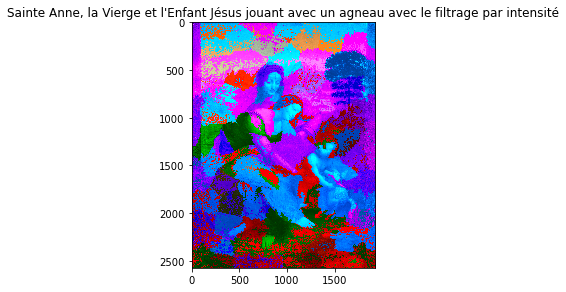

In [99]:
#Affichage de l'image target qu'avec le filtre intensité
color_target_int = cv2.merge((L_t, a_t, b_t))
color_target_int = cv2.cvtColor(color_target_int, cv2.COLOR_LAB2RGB);

imshow(color_target_int)
plt.title("Sainte Anne, la Vierge et l'Enfant Jésus jouant avec un agneau avec le filtrage par intensité")
plt.show()

### Merge  Std Deviation

In [100]:
props = regionprops(segments)
tab_a = []
tab_b = []
a_mean = []
b_mean = []
#Ici il y a les valeurs moyennes a et b de chaque superpixel de référence
for i in range(len(props)):
    indices = props[i].coords
    x, y = indices[:,0], indices[:,1]
    for k in range(len(x)):
        tab_a.append(a[x[k],y[k]])
        tab_b.append(b[x[k],y[k]])
    a_mean.append(int(np.mean(tab_a)))
    b_mean.append(int(np.mean(tab_b)))
    tab_a = []
    tab_b = []


In [101]:
#Trouver la centroide de chaque superpixel target
props_target = regionprops(segments_gray)
x_mean = 0
y_mean = 0
center_x = []
center_y = []
for i in range(len(props_target)):
    indices = props_target[i].coords
    x, y = indices[:,0], indices[:,1]
    center_x.append(int(np.mean(x)))
    center_y.append(int(np.mean(y)))

# Transposer la meilleur valeur refenrece (a,b) au centre de chaque superpixel target 
# Extraire les valeurs a et b de chaque pixel de l'image target en CIELab
img_targ_lab = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
img_targ_lab = cv2.cvtColor(img_targ_lab, cv2.COLOR_BGR2LAB)
L_t, a_t, b_t = cv2.split(img_targ_lab) #Luminosity, a channel, b channel
for i in range (len(np.unique(segments_gray))):
    a_t[[center_x[i]],[center_y[i]]] = a_mean[min_index_std[i]]
    b_t[[center_x[i]],[center_y[i]]] = b_mean[min_index_std[i]]


In [102]:
# Détermination des valeurs (a,b) pour tous les pixels
w_pq = []

for i in range (len(props_target)):
    indices = props_target[i].coords
    x, y = indices[:,0], indices[:,1]
    for k in range (len(x)):
        w_pq = np.exp((-(L_t[center_x[i],center_y[i]]-L_t[x[k],y[k]])**2)/(2*sigma[i]**2))
        a_t[x[k],y[k]] = a_mean[min_index_std[i]] + w_pq * a_t[x[k],y[k]]
        b_t[x[k],y[k]] = b_mean[min_index_std[i]] + w_pq * b_t[x[k],y[k]]

C:\Users\laure\AppData\Local\Temp\ipykernel_14856\725491689.py:8: RuntimeWarning: overflow encountered in ubyte_scalars
  w_pq = np.exp((-(L_t[center_x[i],center_y[i]]-L_t[x[k],y[k]])**2)/(2*sigma[i]**2))


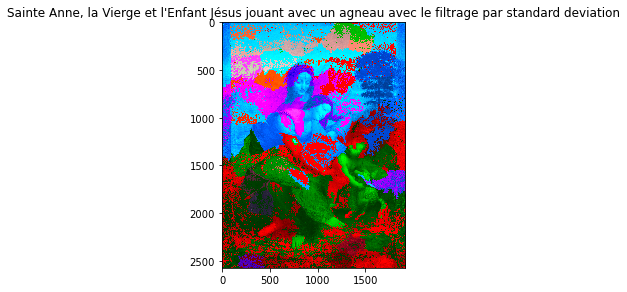

In [103]:
#Affichage de l'image target qu'avec le filtre std deviation
color_target_std = cv2.merge((L_t, a_t, b_t))
color_target_std = cv2.cvtColor(color_target_std, cv2.COLOR_LAB2RGB);

imshow(color_target_std)
plt.title("Sainte Anne, la Vierge et l'Enfant Jésus jouant avec un agneau avec le filtrage par standard deviation")
plt.show()

### Merge gabor

In [104]:
props = regionprops(segments)
tab_a = []
tab_b = []
a_mean = []
b_mean = []
#Ici il y a les valeurs moyennes a et b de chaque superpixel de référence
for i in range(len(props)):
    indices = props[i].coords
    x, y = indices[:,0], indices[:,1]
    for k in range(len(x)):
        tab_a.append(a[x[k],y[k]])
        tab_b.append(b[x[k],y[k]])
    a_mean.append(int(np.mean(tab_a)))
    b_mean.append(int(np.mean(tab_b)))
    tab_a = []
    tab_b = []


In [105]:
#Trouver la centroide de chaque superpixel target
props_target = regionprops(segments_gray)
x_mean = 0
y_mean = 0
center_x = []
center_y = []
for i in range(len(props_target)):
    indices = props_target[i].coords
    x, y = indices[:,0], indices[:,1]
    center_x.append(int(np.mean(x)))
    center_y.append(int(np.mean(y)))

# Transposer la meilleur valeur refenrece (a,b) au centre de chaque superpixel target 
# Extraire les valeurs a et b de chaque pixel de l'image target en CIELab
img_targ_lab = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
img_targ_lab = cv2.cvtColor(img_targ_lab, cv2.COLOR_BGR2LAB)
L_t, a_t, b_t = cv2.split(img_targ_lab) #Luminosity, a channel, b channel
for i in range (len(np.unique(segments_gray))):
    a_t[[center_x[i]],[center_y[i]]] = a_mean[min_index_gabor[i]]
    b_t[[center_x[i]],[center_y[i]]] = b_mean[min_index_gabor[i]]


In [106]:
# Détermination des valeurs (a,b) pour tous les pixels
w_pq = []

for i in range (len(props_target)):
    indices = props_target[i].coords
    x, y = indices[:,0], indices[:,1]
    for k in range (len(x)):
        w_pq = np.exp((-(L_t[center_x[i],center_y[i]]-L_t[x[k],y[k]])**2)/(2*sigma[i]**2))
        a_t[x[k],y[k]] = a_mean[min_index_gabor[i]] + w_pq * a_t[x[k],y[k]]
        b_t[x[k],y[k]] = b_mean[min_index_gabor[i]] + w_pq * b_t[x[k],y[k]]

C:\Users\laure\AppData\Local\Temp\ipykernel_14856\336348817.py:8: RuntimeWarning: overflow encountered in ubyte_scalars
  w_pq = np.exp((-(L_t[center_x[i],center_y[i]]-L_t[x[k],y[k]])**2)/(2*sigma[i]**2))


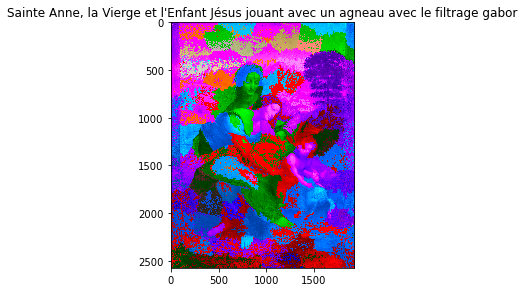

In [107]:
#Affichage de l'image target qu'avec le filtre gabor
color_target_gabor = cv2.merge((L_t, a_t, b_t))
color_target_gabor = cv2.cvtColor(color_target_gabor, cv2.COLOR_LAB2RGB);


imshow(color_target_gabor)
plt.title("Sainte Anne, la Vierge et l'Enfant Jésus jouant avec un agneau avec le filtrage gabor")
plt.show()

### Merge SIFT

In [108]:
props = regionprops(segments)
tab_a = []
tab_b = []
a_mean = []
b_mean = []
#Ici il y a les valeurs moyennes a et b de chaque superpixel de référence
for i in range(len(props)):
    indices = props[i].coords
    x, y = indices[:,0], indices[:,1]
    for k in range(len(x)):
        tab_a.append(a[x[k],y[k]])
        tab_b.append(b[x[k],y[k]])
    a_mean.append(int(np.mean(tab_a)))
    b_mean.append(int(np.mean(tab_b)))
    tab_a = []
    tab_b = []


In [109]:
#Trouver la centroide de chaque superpixel target
props_target = regionprops(segments_gray)
x_mean = 0
y_mean = 0
center_x = []
center_y = []
for i in range(len(props_target)):
    indices = props_target[i].coords
    x, y = indices[:,0], indices[:,1]
    center_x.append(int(np.mean(x)))
    center_y.append(int(np.mean(y)))

# Transposer la meilleur valeur refenrece (a,b) au centre de chaque superpixel target 
# Extraire les valeurs a et b de chaque pixel de l'image target en CIELab
img_targ_lab = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
img_targ_lab = cv2.cvtColor(img_targ_lab, cv2.COLOR_BGR2LAB)
L_t, a_t, b_t = cv2.split(img_targ_lab) #Luminosity, a channel, b channel
for i in range (len(np.unique(segments_gray))):
    a_t[[center_x[i]],[center_y[i]]] = a_mean[min_index_sift[i]]
    b_t[[center_x[i]],[center_y[i]]] = b_mean[min_index_sift[i]]


In [110]:
# Détermination des valeurs (a,b) pour tous les pixels
w_pq = []

for i in range (len(props_target)):
    indices = props_target[i].coords
    x, y = indices[:,0], indices[:,1]
    for k in range (len(x)):
        w_pq = np.exp((-(L_t[center_x[i],center_y[i]]-L_t[x[k],y[k]])**2)/(2*sigma[i]**2))
        a_t[x[k],y[k]] = a_mean[min_index_sift[i]] + w_pq * a_t[x[k],y[k]]
        b_t[x[k],y[k]] = b_mean[min_index_sift[i]] + w_pq * b_t[x[k],y[k]]

C:\Users\laure\AppData\Local\Temp\ipykernel_14856\351499937.py:8: RuntimeWarning: overflow encountered in ubyte_scalars
  w_pq = np.exp((-(L_t[center_x[i],center_y[i]]-L_t[x[k],y[k]])**2)/(2*sigma[i]**2))


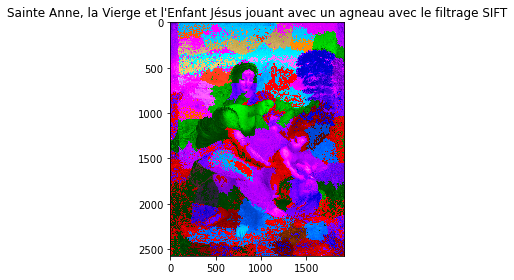

In [112]:
#Affichage de l'image target qu'avec le filtre SIFT
color_target_sift = cv2.merge((L_t, a_t, b_t))
color_target_sift = cv2.cvtColor(color_target_sift, cv2.COLOR_LAB2RGB);
plt.title("Sainte Anne, la Vierge et l'Enfant Jésus jouant avec un agneau avec le filtrage SIFT")
imshow(color_target_sift)